# Прогнозирование количества заказов такси<a class="tocSkip">

Требуется построить модель машинного обучения для прогнозирования количества заказов такси на следующий час на основе исторических данных.
    
Значение метрики RMSE на тестовой выборке должно быть <= 48.
                                                           
Использовались следующие модели:
- Градиентный бустинг (CatBoost),
- Линейная регрессия                                                           

### План работы<a class="tocSkip">
1. [Подготовка](#Подготовка)
2. [Анализ](#Анализ)
3. [Обучение](#Обучение)
4. [Тестирование](#Тестирование)    
5. [Общий вывод](#Общий-вывод)

### Описание данных<a class="tocSkip">
Дата-время и количество заказов такси.

# Подготовка

In [1]:
#импортирование нужных библиотек:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

import time
from tqdm.notebook import tqdm

#визуализация
import matplotlib.pyplot as plt

#игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col=0)
except:
    data = pd.read_csv('datasets/taxi.csv', parse_dates = [0], index_col=0)

In [3]:
def examine_datetime_df(df):
    display(df.head(10))
    display(df.info())
    display(df.describe())
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.style.format('{:.1f}', subset='Percent')
    
    print('Монотонный ли индекс ', data.index.is_monotonic)
    print(f'Количество пропусков {missing_data}')    
    print('_____________________________________________')

Исследуем данные:

In [4]:
examine_datetime_df(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Монотонный ли индекс  True
Количество пропусков             Total  Percent
num_orders      0      0.0
_____________________________________________


Данные без пропусков, индекс монотоннен, все хорошо. Проведем ресемплинг по 1 часу:

In [5]:
data = data.resample('1H').sum()

In [6]:
examine_datetime_df(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Монотонный ли индекс  True
Количество пропусков             Total  Percent
num_orders      0      0.0
_____________________________________________


# Анализ

In [7]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4416, freq='H')

Посмотрим на тренды и сезонность:

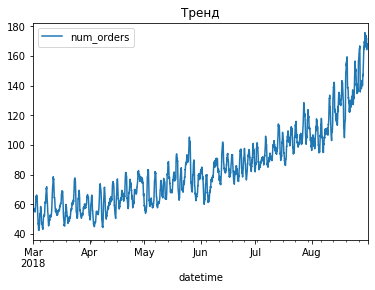

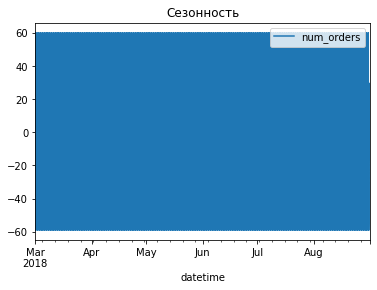

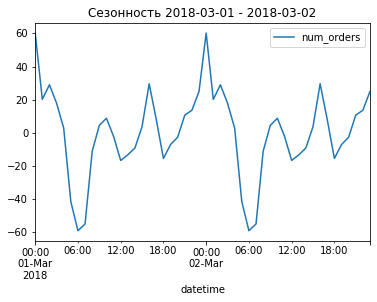

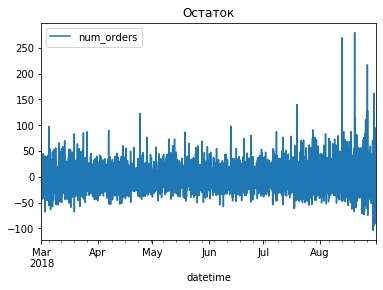

In [8]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(title='Тренд')
decomposed.seasonal.plot(title='Сезонность')
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(title='Сезонность 2018-03-01 - 2018-03-02')
decomposed.resid.plot(title='Остаток')

Общий тренд - количество заказов такси растет. Ночью заказов меньше, чем днем, минимальное значение около 6 утра, максимальное количество заказов всегда в районе полуночи.

# Обучение

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = data.index.year
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data

In [10]:
def split_data(data):
    features = data.drop('num_orders', axis=1)
    target = data['num_orders']

    features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1, random_state=12345)
    null_features = features_train[features_train.isnull().any(axis=1)].index.tolist()
    
    target_train.drop(null_features, axis=0, inplace=True)
    
    features_train.dropna(inplace=True)
    return features_train, features_test, target_train, target_test

Результаты обучения будем записывать в таблицу:

In [11]:
results = pd.DataFrame([], columns = ['model','rmse', 'time', 'lag', 'window', 'parameters'])

In [12]:
models = [CatBoostRegressor(logging_level='Silent'), RandomForestRegressor()]
params = {'n_estimators':range(100, 400, 50), 'max_depth':range(1,6)}

for lag in tqdm(range(1,5), desc='lag'):
    for window in tqdm(range(1,5), desc='window'):
        df = make_features(data, lag, window)
        features_train, features_test, target_train, target_test = split_data(df)
        for model in models:
            tscv = TimeSeriesSplit(n_splits=2)        
            gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=params, scoring='neg_mean_squared_error')
            start_time = time.time()
            gsearch.fit(features_train, target_train)
            time_edu= time.time() - start_time
            new_row = {'model': model,'rmse':np.sqrt(-1*gsearch.best_score_), 'time':time_edu, 'lag':lag, 'window':window, 'parameters':gsearch.best_params_}
            
            results = results.append(new_row, ignore_index=True)
                    

In [13]:
params_lr = {'fit_intercept':[True,False], 'normalize':[True,False]}
model = LinearRegression()
for lag in tqdm(range(1,5), desc='lag'):
    for window in tqdm(range(1,5), desc='window'):
        df = make_features(data, lag, window)
        features_train, features_test, target_train, target_test = split_data(df)
        tscv = TimeSeriesSplit(n_splits=2)        
        gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=params_lr, scoring='neg_mean_squared_error')
        start_time = time.time()
        gsearch.fit(features_train, target_train)
        time_edu= time.time() - start_time
        new_row = {'model': model,'rmse':np.sqrt(-1*gsearch.best_score_), 'time':time_edu, 'lag':lag, 'window':window, 'parameters':gsearch.best_params_}
        results = results.append(new_row, ignore_index=True)
        

In [14]:
results = results.sort_values(by=['rmse','time'])
display(results)

,model,rmse,time,lag,window,parameters
16,<catboost.core.CatBoostRegressor object at 0x7...,29.197535,139.699100,3,1,"{'max_depth': 5, 'n_estimators': 350}"
20,<catboost.core.CatBoostRegressor object at 0x7...,29.255401,129.709845,3,3,"{'max_depth': 5, 'n_estimators': 350}"
18,<catboost.core.CatBoostRegressor object at 0x7...,29.299220,156.985659,3,2,"{'max_depth': 5, 'n_estimators': 350}"
22,<catboost.core.CatBoostRegressor object at 0x7...,29.299356,133.240704,3,4,"{'max_depth': 4, 'n_estimators': 350}"
24,<catboost.core.CatBoostRegressor object at 0x7...,29.330168,150.581972,4,1,"{'max_depth': 5, 'n_estimators': 350}"
12,<catboost.core.CatBoostRegressor object at 0x7...,29.354188,138.472223,2,3,"{'max_depth': 5, 'n_estimators': 350}"
4,<catboost.core.CatBoostRegressor object at 0x7...,29.390654,153.446267,1,3,"{'max_depth': 5, 'n_estimators': 350}"
28,<catboost.core.CatBoostRegressor object at 0x7...,29.434979,142.964478,4,3,"{'max_depth': 5, 'n_estimators': 350}"
30,<catboost.core.CatBoostRegressor object at 0x7...,29.455638,143.751579,4,4,"{'max_depth': 5, 'n_estimators': 350}"
6,<catboost.core.CatBoostRegressor object at 0x7...,29.456330,128.982785,1,4,"{'max_depth': 5, 'n_estimators': 350}"


Наилучшее значение RMSE показал CatBoostRegressor, c размером лага 3 и окном для плавающего среднего = 1.

# Тестирование

In [15]:
df = make_features(data, results.iloc[0]['lag'], results.iloc[0]['window'])
features_train, features_test, target_train, target_test = split_data(df)
model = CatBoostRegressor(logging_level='Silent', max_depth=results.iloc[0]['parameters']['max_depth'], n_estimators=results.iloc[0]['parameters']['n_estimators'])

model.fit(features_train, target_train)
predict_test = model.predict(features_test)
mse = mean_squared_error(target_test, predict_test)
rmse = mse ** 0.5
print('RMSE для тестовой выборки, ', rmse)


RMSE для тестовой выборки,  47.644739205855366


In [16]:
result = pd.DataFrame(columns = ['target_test','predict_test'])
result['target_test'] = target_test
result['predict_test'] = predict_test
display(result)

,target_test,predict_test
datetime,,
2018-08-13 14:00:00,102,104.277742
2018-08-13 15:00:00,175,113.691232
2018-08-13 16:00:00,144,133.550112
2018-08-13 17:00:00,152,104.904111
2018-08-13 18:00:00,104,102.077792
...,...,...
2018-08-31 19:00:00,136,109.401742
2018-08-31 20:00:00,154,108.255630
2018-08-31 21:00:00,159,130.287670


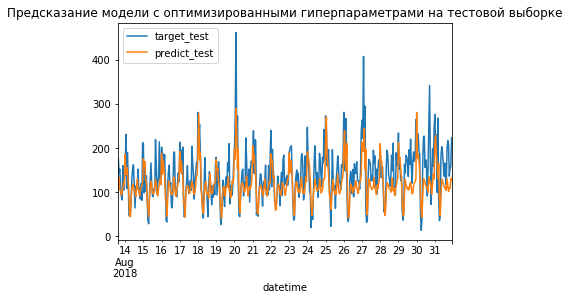

In [17]:
result.plot(title='Предсказание модели с оптимизированными гиперпараметрами на тестовой выборке')

In [18]:
predict_test = target_test.shift(fill_value=target_train[-1])
mse = mean_squared_error(target_test, predict_test)
rmse = mse ** 0.5
print('RMSE для тестовой выборки Dummy, ', rmse)

RMSE для тестовой выборки Dummy,  58.856486242815066


In [19]:
result = pd.DataFrame(columns = ['target_test','predict_test'])
result['target_test'] = target_test
result['predict_test'] = predict_test
display(result)

,target_test,predict_test
datetime,,
2018-08-13 14:00:00,102,119
2018-08-13 15:00:00,175,102
2018-08-13 16:00:00,144,175
2018-08-13 17:00:00,152,144
2018-08-13 18:00:00,104,152
...,...,...
2018-08-31 19:00:00,136,207
2018-08-31 20:00:00,154,136
2018-08-31 21:00:00,159,154


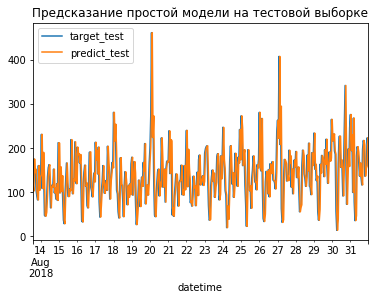

In [20]:
result.plot(title='Предсказание простой модели на тестовой выборке')

# Общий вывод

Данные о количестве вызовов такси были подготовлены, проанализированы. Общий тренд для данных - количество заказов растет. Наблюдается сезонность: ночью заказов меньше с минимумом около 6 утра и максимумом около полуночи. 

Для обучения были выбраны CatBoostRegressor и RandomForestRegressor. Лучшее качество предсказания показала CatBoost. На тестовой выборке значение RMSE меньше 48 и меньше простой модели, предсказывающей среднее значение.